<p style="font-size:26px;text-align:center"> <b> EYE PROBLEMS - BLINDNESS DETECTION </b> </p>

**1. Business Problem**

**1.1. Description**

Source : https://www.kaggle.com/c/aptos2019-blindness-detection

Data : 

As we have Diabetic Retinopathy grades available only for train fundus images (3662), we used other sources to have some more fundus images for training.

*   2019 APTOS Fundus images - https://www.kaggle.com/c/aptos2019-blindness-detection
*   IDRiD Fundus images  - https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid 
*   MESSIDOR Fundus images - https://www.adcis.net/en/third-party/messidor/ 


Download train & test fundus images, and their respective DR grades csv file

**Problem statement:**

As of now, they rely on highly trained doctors to review the images of the retina and provide diagnosis. So, our goal is to scale their efforts through technology; by building a robust ML/DL trained models, to identify potential patients for diabetic retinopathy.


Image creadit : https://www.eye7.in/retina/diabetic-retinopathy/complete-guide/

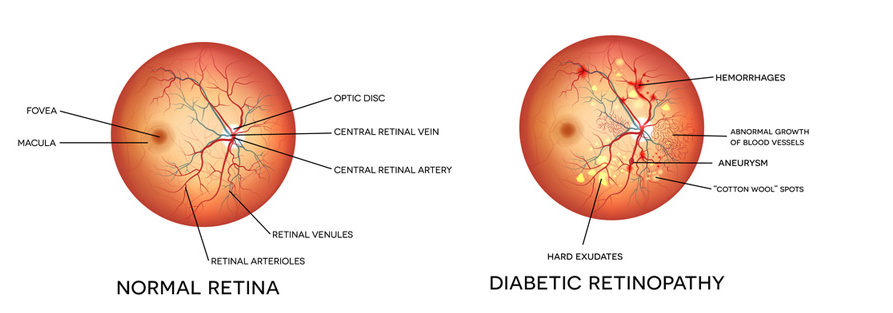


**Hemorrhage** - The release of blood from a broken blood vessel, either inside or outside the body.

**Abnormal growth of blood vessels** - abnormal growth of the three kinds of blood vessels are arteries, veins, and capillaries

**Aneurysm** - A ballooning and weakened area in an artery.

**Cotton wool spots** - They appear as fluffy white patches on the retina. They are caused by damage to nerve fibers.

**Hard exudates** - small white or yellowish white deposits with sharp margins

**1.2. Source/Useful Links**

Some articles and reference blogs about the problem statement

https://arxiv.org/abs/2003.02261

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0233514

**1.3. Real-world/Business objectives and constraints**

* No low-latency requirement
* Interpretability is important
* Errors can be very costly

**2. Machine Learning Problem Formulation**

**2.1. Data**

**2.1.1. Data Overview**

*   We are given with set of fundus images and their respective DR grades(0 to 4) file


**Fundus photography** involves photographing the rear of an eye; also known as the fundus. Specialized fundus cameras consisting of an intricate microscope attached to a flash enabled camera are used in fundus photography. The main structures that can be visualized on a fundus photo are the central and peripheral retina, optic disc and macula. Fundus photography can be performed with colored filters, or with specialized dyes including fluorescein and indocyanine green

**Fundus images used from the below datasets:**

*   2019 APTOS Fundus images -3662
*   IDRiD Fundus images - 516
*   MESSIDOR Fundus images - 1212

**Diabetic retinopathy grades 0 to 4**

0 - No DR

1 - Mild - the earliest stage, where only microaneurysms can occur

2 - Moderate - a stage which can be described by losing the blood vessels ability of blood transportation due to their distortion and swelling with the progress of the disease

3 - Severe - a stage that results in deprived blood supply to the retina due to the increased blockage of more blood vessels, hence signaling the retina for the growing of fresh blood vessels

4 - Proliferative DR - is the advanced stage, where the growth features secreted by the retina activate proliferation of the new blood vessels, growing along inside covering of retina in some vitreous gel, filling the eye.


**2.1.2. Example Data Point**

**Below are the few sample Fundus images from the datasets**

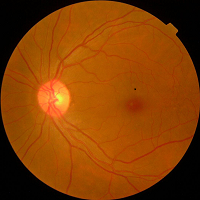

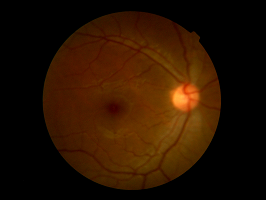

**DR Grades file**

id_code, diagnosis

000c1434d8d7, 2

001639a390f0, 4

**2.2. Mapping the real-world problem to an ML problem**

**2.2.1. Type of Machine Learning Problem**

Multi class Classification problem

**2.2.2. Performance Metric**

Metric(s):

**1.  Quadratic weighted kappa score** - 

It measures the agreement between two ratings. It typically varies from 0 - random agreement between raters to 1 - complete agreement between raters.

**5 step breakdown for Weighted Kappa Metric**

*   First, create a multi class confusion matrix O between predicted and actual ratings.
*   Second, construct a weight matrix w which calculates the weight between the actual and predicted ratings.
*   Third, calculate value_counts() for each rating in preds and actuals.
*   Fourth, calculate E, which is the outer product of two value_count vectors
*   Fifth, normalise the E and O matrix .Caclulate, weighted kappa as per formula

The kappa score K is:

K = 1− W(ij) * O(ij) /  W(ij) * E(ij) ; O - Observed values , E - Expected values

W = (i-j)^2 / (k-1)^2 ; k - no of categories 

reference URL - https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps


**2.   Macro -F1 score -** 

Macro -precision, recall & F1 score - an arithametic mean of the per-class F1 Scores, and it gives equal importance to each class. So, it can be used for Imbalanced test data. 

Lets say example: In our dataset, 95 - Positive & 5 - Negative points. If our dumb model predicts all points are positive - the simple precision would be 95, recall - 100 & F1 score is - 97.4 - shows like our model is good where we misclassified minority class which not considered for calculation. Whereas, if we employ Macro-precision, recall & F1 score - we get the better understanding of our model performance. 

Step 1: Need to calculate recall for each class - Recall of positive - 100 & Negative - 0

Step 2: Need to calculate precision for each class - precision of positive - 95 & Negative - 0

Step 3: Calculating F1 score for each class -  F1 for poistive - 97.4 & Negative - 0

Step 4: Apply arithametic mean of the per-class F1 Scores- (97.4 + 0)/ 2 = 48.7 - It clearly shows it is a below average model. So we can improve our model.


**Importing all the libraries**

In [87]:
import glob
import pandas as pd
import numpy as np
import os
import cv2
import imageio
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [4]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


**3. Preprocessing**

**3.1 Reading data**

In [5]:
# Custom method -  to fetch the actual path & name of all the images
def abs_path(path, folder):
    img_path = list()
    img_fullname = list()
    img_name = list()
    for i in folder:
        images = glob.glob(path + i + '/*.*')
        for j in images:
            img_path.append(j)
            temp = j.split("/")[-1]
            img_fullname.append(temp)
            temp = temp.split(".")[0]
            img_name.append(str(temp))
    return img_path, img_fullname, img_name

In [6]:
folder_name = ['train_images', 'IDRID_test', 'IDRID_train', 'messidor'] # List of folders 
path = '/content/drive/MyDrive/Colab_Notebooks/Case_study2/'  
img_path, img_fullname, img_name = abs_path(path, folder_name) # calling abs_path method

In [7]:
df = pd.DataFrame()  # Storing the path & name of the images into the dataframe
df['img_path'] = img_path
df['img_fullname'] = img_fullname
df['id_code'] = img_name

In [8]:
# Reading DR grades files of 2019, Messidor & IDRiD
train2019 = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/train.csv')
train2019 = train2019[['id_code', 'diagnosis']]
messidor = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/messidor_data.csv')
messidor = messidor[['id_code', 'diagnosis']]
idridtrain = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/IDRID_Training_Labels.csv')
idridtrain = idridtrain[['id_code', 'diagnosis']]
idridtest = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/IDRID_Testing_Labels.csv')
idridtest = idridtest[['id_code', 'diagnosis']]

In [9]:
# Fetching DR grades of the respective images of 2019, IDRiD & Messidor data
labels = list()
id_code = list()
for i, j in train2019.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

for i, j in messidor.iterrows():
    id_code.append(j['id_code'].split(".")[0])
    labels.append(j['diagnosis'])

for i, j in idridtrain.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

for i, j in idridtest.iterrows():
    id_code.append(j['id_code'])
    labels.append(j['diagnosis'])

In [10]:
train_labels = pd.DataFrame() # Storing the image file name & DR grades into the dataframe
train_labels['id_code'] = id_code
train_labels['diagnosis'] = labels

In [11]:
# Merging the image path & DR grades 
df = pd.merge(df, train_labels, on='id_code', how='left')

In [12]:
df = df[df['diagnosis'].notna()] # removing row if the DR grade is NaN

In [13]:
print(df[df['diagnosis'].isnull()]) # Verify if there is any NaN present in the DR grades field

Empty DataFrame
Columns: [img_path, img_fullname, id_code, diagnosis]
Index: []


In [14]:
dia_code = list()   # Converting the data type of DR grades field from Float to Int
for i, j in df.iterrows():
    dia_code.append(int(j['diagnosis']))

In [15]:
del df['diagnosis'] # removing the existing DR grades field with data type as Float

In [16]:
df['diagnosis'] = dia_code # adding DR grades with data type as Int

In [17]:
df.reset_index(drop = True, inplace = True) #index reset

In [18]:
df

,img_path,img_fullname,id_code,diagnosis
0,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b8ac328009e0.png,b8ac328009e0,2
1,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b87f9c59748b.png,b87f9c59748b,4
2,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b8e20c076b03.png,b8e20c076b03,0
3,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b89938407ee6.png,b89938407ee6,2
4,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b90bc89ce8d8.png,b90bc89ce8d8,4
...,...,...,...,...
5436,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37078_0400_PP.tif,20051117_37078_0400_PP,0
5437,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37100_0400_PP.tif,20051117_37100_0400_PP,0
5438,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37130_0400_PP.tif,20051117_37130_0400_PP,0
5439,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37155_0400_PP.tif,20051117_37155_0400_PP,0


**3.2 Separation of green channel of images followed by Image smoothing**

**Steps followed in preprocessing:**

*   **Step 1:** Green Channel of the three color channels in the image (Red, Green, and Blue) the contrast between the blood vessels, exudates and hemorrhages are best seen in the green channel and this channels neither under- illuminated nor over-saturated like the other two. Hence, we have extracted only the green channel for analysis and classification.


*   **Step 2:** Contrast Enhancement to further enhance the features of the image, contrast limited adaptive histogram equalization is performed


*   **Step 3:** Draw a circle around image centre 


*   **Step 4:** Resizing the image into 512 * 512 

*   **Step 5:** Cropping Uninformative area around the circle

*   **Step 6:** Image smoothing


**Here is the demo of preprocessing for the sample image::**






In [121]:
# The preprocessing concept acquired from -https://biomedpharmajournal.org/vol10no2/diabetic-retinal-fundus-images-preprocessing-and-feature-extraction-for-early-detection-of-diabetic-retinopathy/
# Code reference for cropping and image smoothing - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

img = cv2.imread(df['img_path'].values[0]) # Reading image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting color space to RGB

# Step1 - Seperation of green channel of images
red, green, blue = cv2.split(img) 

# Step2 - Contrast enhancement by applying CLAHE technique to improve the contrast of images - 
# the concept acquired from https://stackoverflow.com/questions/38504864/opencv-clahe-parameters-explanation
cla = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
e_img = cla.apply(green)

# Step3 - Draw a circle around image centre 
height, width = e_img.shape    
x = int(width/2)  # X co-ordinate
y = int(height/2) # Y co-ordinate
r = np.amin((x,y)) # radius of the circle
circle_img = np.zeros((height, width), np.uint8) 
cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1) # method to draw a circle on image 
c_img = cv2.bitwise_and(e_img, e_img, mask=circle_img)  # fitting the circle on image using a bitwise_and 

# Step4 - Resizing the image into 512 * 512 
rimg = cv2.resize(c_img, (512, 512)) # resizing the image 

# Step5 - Cropping Uninformative area around the circle
mask = rimg > 7 # Set True if the pixel value greater than the tolerance value which is 7, Tolerance define "how much black" we can tolerate. If we set this number too high, it will correspond to bright pixel (0=black, 255=white), so it will not crop anything  
# Construct an open mesh from multiple sequence - reference https://stackoverflow.com/questions/62505046/what-does-numpy-ix-function-do-and-what-is-the-output-used-for
rimg =  rimg[np.ix_(mask.any(1),mask.any(0))] 


# Step6 - Image smoothing
# addWeighted - it helps in adding two images and also blending those by passing the alpha (4), beta (-4) and gamma (128) values - alpha * image1 + beta * image2 + gamma
# GaussianBlur - It used Gaussian filter is a low-pass filter that removed the high frequency components are reduced
fin_img=cv2.addWeighted(rimg,4, cv2.GaussianBlur( rimg , (0,0) , 10) ,-4 ,128) 

**Plotting of the pre-processing image at each stage**

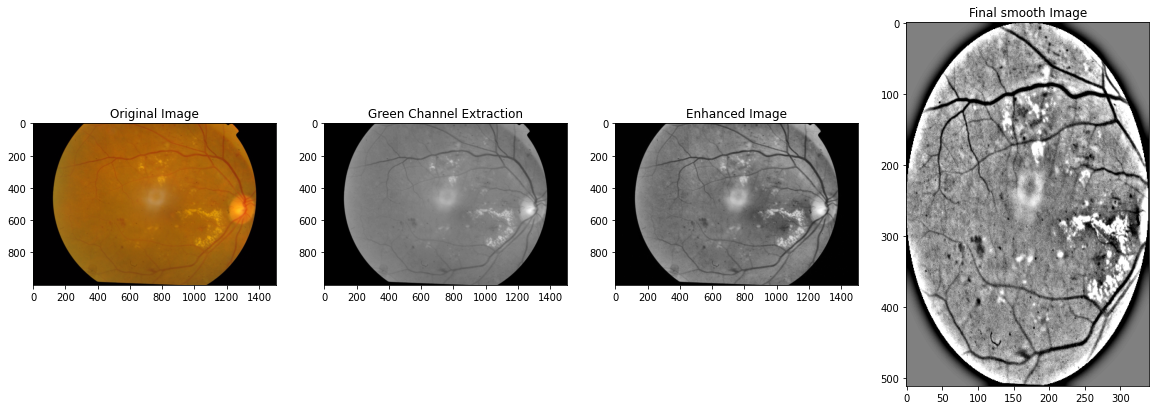

In [122]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1, 4, 1)
ax1.set_title("Original Image")
ax1.imshow(img)

ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("Green Channel Extraction")
ax2.imshow(green, cmap="binary_r")

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title("Enhanced Image")
ax3.imshow(e_img, cmap="binary_r")

ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title("Final smooth Image")
ax4.imshow(fin_img, cmap="binary_r")

plt.show()

**3.3 Custom method to preprocess all the images**

In [80]:
# This concept acquired from https://biomedpharmajournal.org/vol10no2/diabetic-retinal-fundus-images-preprocessing-and-feature-extraction-for-early-detection-of-diabetic-retinopathy/
# Code reference for cropping and image smoothing - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

def preprocess_img(img_df):
    os.makedirs('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed')
    pre_path = list()
    pre_filename = list()
    dr_grade = list()
    for i in tqdm(range(len(df['img_path'].values))):
        pre_path.append('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed/' + df['id_code'].values[i] + '.png')
        pre_filename.append(df['id_code'].values[i])
        dr_grade.append(df['diagnosis'].values[i])
  
        img = cv2.imread(df['img_path'].values[i]) # Reading image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting color space to RGB

        # Step1 - Seperation of green channel of images
        red, green, blue = cv2.split(img) 

        # Step2 - Contrast enhancement by applying CLAHE technique to improve the contrast of images - 
        # the concept acquired from https://stackoverflow.com/questions/38504864/opencv-clahe-parameters-explanation  
        cla = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
        e_img = cla.apply(green)

        # Step3 - Draw a circle around image centre 
        height, width = e_img.shape    
        x = int(width/2)  # X co-ordinate
        y = int(height/2) # Y co-ordinate
        r = np.amin((x,y)) # radius of the circle
        circle_img = np.zeros((height, width), np.uint8) 
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1) # method to draw a circle on image 
        c_img = cv2.bitwise_and(e_img, e_img, mask=circle_img)  # fitting the circle on image using a bitwise_and 

        # Step4 - Resizing the image into 512 * 512 
        rimg = cv2.resize(c_img, (512, 512)) # resizing the image 

        # Step5 - Cropping Uninformative area around the circle
        mask = rimg > 7 # Set True if the pixel value greater than the tolerance value which is 7
        rimg =  rimg[np.ix_(mask.any(1),mask.any(0))] # Construct an open mesh from multiple sequence - reference https://stackoverflow.com/questions/62505046/what-does-numpy-ix-function-do-and-what-is-the-output-used-for

        # Step6 - Image smoothing
        # addWeighted - it helps in adding two images and also blending those by passing the alpha (4), beta (-4) and gamma (128) values - alpha * image1 + beta * image2 + gamma
        # GaussianBlur - It used Gaussian filte is a low-pass filter that removed the high frequency components are reduced
        fin_img=cv2.addWeighted(rimg,4, cv2.GaussianBlur( rimg , (0,0) , 10) ,-4 ,128) 

        img_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed/','{}.png'.format(df['id_code'].values[i]))
        cv2.imwrite(img_path, fin_img)
        
    return pre_path, pre_filename, dr_grade

In [82]:
pre_path, pre_filename, dr_grade = preprocess_img(df)

100%|██████████| 5441/5441 [1:21:05<00:00,  1.12it/s]


In [110]:
pre_df = pd.DataFrame()  # Stroing the paths and DR grades of the preprocessed images 
pre_df['img_path'] = pre_path
pre_df['filename'] = pre_filename
pre_df['diagnosis'] = dr_grade

In [111]:
pre_df

,img_path,filename,diagnosis
0,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b8ac328009e0,2
1,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b87f9c59748b,4
2,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b8e20c076b03,0
3,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b89938407ee6,2
4,/content/drive/MyDrive/Colab_Notebooks/Case_st...,b90bc89ce8d8,4
...,...,...,...
5436,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37078_0400_PP,0
5437,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37100_0400_PP,0
5438,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37130_0400_PP,0
5439,/content/drive/MyDrive/Colab_Notebooks/Case_st...,20051117_37155_0400_PP,0


In [112]:
pre_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/preprocessed_images.csv')

**4. Exploratory Data Analysis**

**4.1 Class labels distribution**

In [85]:
pre_df['diagnosis'].value_counts()

0    2475
2    1535
1     609
4     419
3     403
Name: diagnosis, dtype: int64

Text(0.5, 1.0, 'Distribution of class labels')

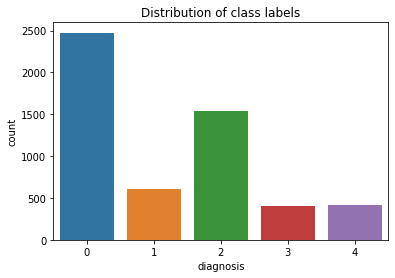

In [89]:
total = len(pre_df)*1
ax=sns.countplot(x="diagnosis", data=pre_df)
plt.title("Distribution of class labels")

**Observation :**

*   Its an unbalanced data. More no of samples for No DR category. 
*   Severe - 3 & Proliferative - 4 - size of these samples considerbly a very less than other categories



**4.2 Plot summary of some random original images**

In [119]:
def img_plot(df):
  g = df.groupby('diagnosis')
  plt_df = g.apply(lambda x: x.sample(5).reset_index(drop=True))
  plt_df = plt_df.reset_index(drop = True)

  for i in range(5):
    fig, ax = plt.subplots(1,5,figsize = (15,15))
    plt_df1 = plt_df[plt_df.index.isin([i,i+5,i+10,i+15,i+20])]
    for j in range(5):
      img = cv2.imread(plt_df1.img_path.iloc[j])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax[j].imshow(img)
      ax[j].set_xlabel('DR Grade'+str(plt_df1.diagnosis.iloc[j]))

    plt.show()

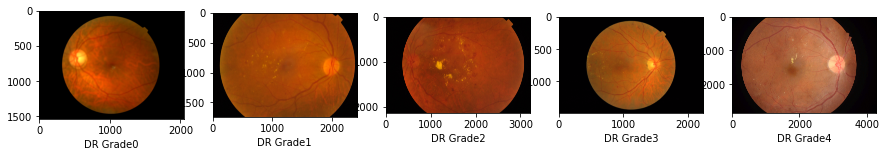

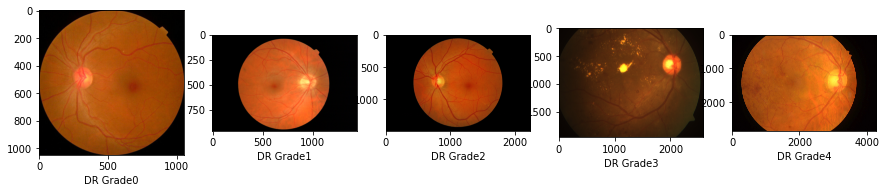

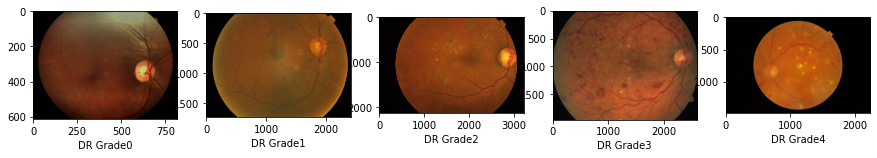

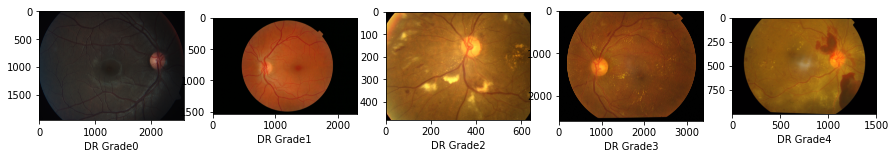

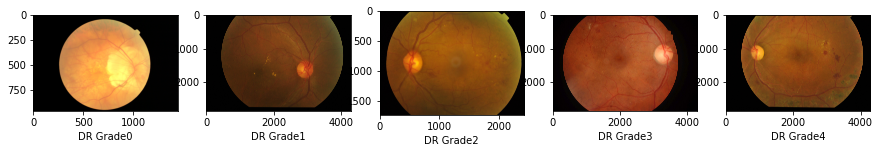

In [114]:
img_plot(df)

**Observation :**

*   As the blood vessels and retina are in the red color, no much clarity on DR grades



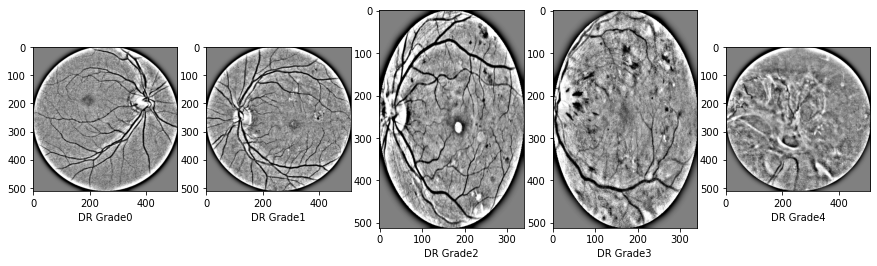

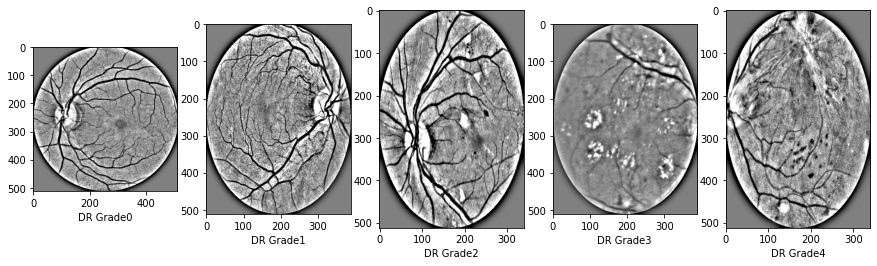

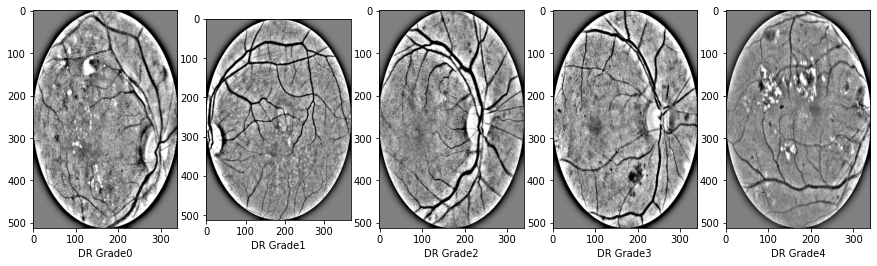

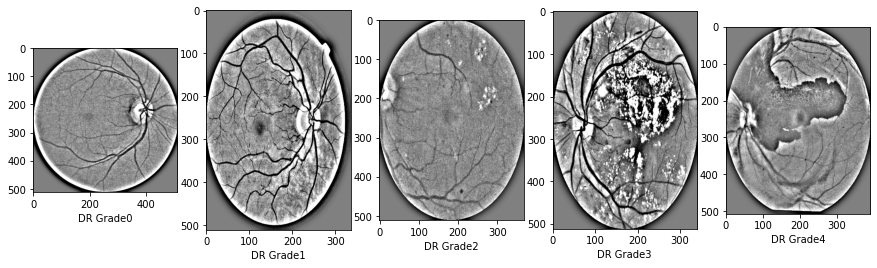

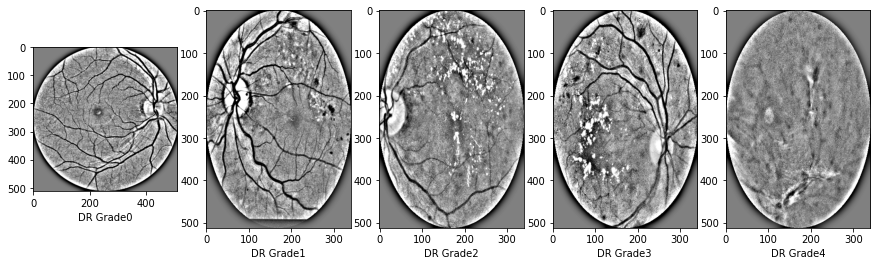

In [120]:
img_plot(pre_df)

**Observation:**

*   We can find the DR grades a bit easier by seeing the preprocessed fundus images
*   There are many patches, and white space on the DR grade 3 & 4 preprocessed fundus images
*   No much patches and white space on the DR grade 0 preprocessed fundus images




**Final Conclusions/Observation:**

*   As we have Diabetic Retinopathy grades available only for train fundus images (3662), we used other sources IDRiD and MESSIDOR datasets along with 2019 data, to have some more fundus images for training.
*   As part of the preprocessing, we have separated the green channel of images because the blood vessels, exudates and hemorrhages are best seen in the green channel.
*   After that, we applied the CLAHE technique on images to improve the contrast of the image, and then cropping around center on images and resized to 512 * 512.
*   At last, applied GaussianBlur for image smoothing
*   Its an unbalanced data. More no of samples for No DR category.
*   Severe - 3 & Proliferative - 4 - size of these samples considerbly a very less than other categories
*   As the blood vessels and retina are in the red color, no much clarity on DR grades on the original fundus images.
*   We can find the DR grades a bit easier by seeing the preprocessed fundus images 
*   There are many patches, and white space on the DR grade 3 & 4 preprocessed fundus images
*   No much patches and white space on the DR grade 0 preprocessed fundus images










